## Import ##

In [2]:
import os
import cv2
import pickle

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score, silhouette_score, davies_bouldin_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input



## Dataset Loading ##

Train set: (7624, 50176), Labels: 53
Validation set: (265, 50176), Labels: 53
Test set: (265, 50176), Labels: 53


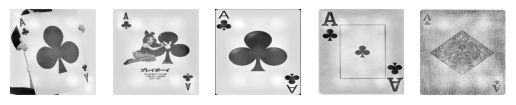

In [4]:

def load_images_from_directory(base_dir):
    x = []  # data from images
    y = []  # labels
    labels = []  # name labels map

    for label_idx, label_name in enumerate(sorted(os.listdir(base_dir))):
        label_path = os.path.join(base_dir, label_name)
        if os.path.isdir(label_path):
            labels.append(label_name)  # name of each label (e.g.: ace of hearts)
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)
                if file_path.endswith(('.jpg', '.jpeg', '.png')):
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    #image_resized = cv2.resize(image, (64, 64))  # ridimensiona per uniformare e costo minore
                    # in ogni caso tutte le immagini sono 224x224
                    x.append(image.flatten())  # mette immagine in un array monodimensionale
                    y.append(label_idx)

    return np.array(x), np.array(y), labels

# dir del dataset
base_dir = "dataset"

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

x_train, y_train, labels_train = load_images_from_directory(train_dir)  # per addestrare il modello
x_valid, y_valid, labels_valid = load_images_from_directory(valid_dir)  # valutare la performance del modello su dati che non sono stati visti durante l'addestramento
x_test, y_test, labels_test = load_images_from_directory(test_dir)  # valutazione finale e imparziale del modello

# assert di controllo per controllare tutti i nomi uguali
assert labels_train == labels_valid == labels_test, "Le etichette non corrispondono tra train, valid e test"

scaler = StandardScaler()
# Fit e trasformazione sui dati di training (!)
x_train = scaler.fit_transform(x_train)
# Solo trasformazione sui dati di validazione
x_valid = scaler.transform(x_valid)

print(f"Train set: {x_train.shape}, Labels: {len(np.unique(y_train))}")
print(f"Validation set: {x_valid.shape}, Labels: {len(np.unique(y_valid))}")
print(f"Test set: {x_test.shape}, Labels: {len(np.unique(y_test))}")

# plot delle prime 5 immagini
fig, axs = plt.subplots(1, 5)

for i in range(5):

    # fare il reshape perchè è flatten (ogni riga ha spalmato tutti i pixel)
    axs[i].imshow(x_train[i].reshape(224, 224), cmap='gray')
    axs[i].axis('off')  # disattiva gli assi
    
plt.show()


## PCA, LDA and T-SNE ##

PCA Explained Variance Ratio (EVR)
n_components:  3 - EVR:  0.48939913612911556
n_components:  8 - EVR:  0.5774487526412625
n_components:  100 - EVR:  0.7813622704982338
n_components:  250 - EVR:  0.8447752961769824
LDA Explained Variance Ratio (EVR)
n_components:  3 - EVR:  0.4649803741729763
n_components:  10 - EVR:  0.6299931860515312
n_components:  25 - EVR:  0.8231518196103103
n_components:  50 - EVR:  0.9917623621888675


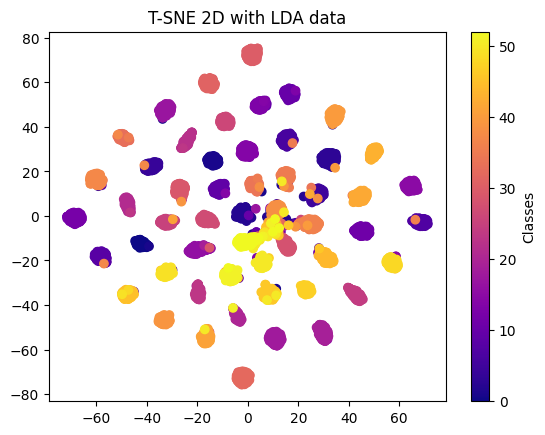

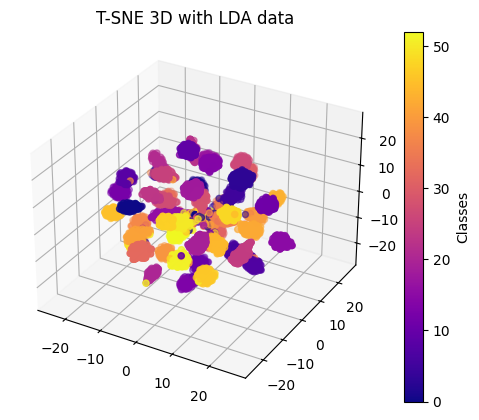

In [40]:

############
# PCA part #
############

#pca_components = [250]
pca_components= [3, 8, 100, 250]
x_train_pca = []
x_valid_pca = []

print("PCA Explained Variance Ratio (EVR)")
for n in pca_components:
    #break
    pca = PCA(n_components=n)
    x_train_pca.append(pca.fit_transform(x_train))  # dati
    # solo transform su dati di validazione
    x_valid_pca.append(pca.transform(x_valid))  # dati
    print("n_components: ", n, "- EVR: ", np.sum(pca.explained_variance_ratio_, axis=0))


############
# LDA part #
############

# 0.4649803741729743 - 3
# 0.5237363824885695 - 5
# 0.5933904948389583 - 8
# 0.6129743521331162 - 9
# 0.6299931860515301 - 10
# 0.7068885625133411 - 15
# 0.9917623621888673 - 50
# Con LDA, il numero massimo di componenti è limitato a (k−1), dove k è il numero di classi
#lda_components = [15]  # 'faster' computation
lda_components = [3, 10, 25, 50]
x_train_lda = []
x_valid_lda = []

print("LDA Explained Variance Ratio (EVR)")
for n in lda_components:
    #break
    lda = LinearDiscriminantAnalysis(n_components=n)
    x_train_lda.append(lda.fit_transform(x_train, y_train))  # dati e label
    x_valid_lda.append(lda.transform(x_valid))  # dati e label
    print("n_components: ", n, "- EVR: ", np.sum(lda.explained_variance_ratio_, axis=0))


##############
# T-SNE part #
##############

#tsne_components = [2]  # 'faster' computation
tsne_components = [2, 3]  # per visualizzazione 2D e 3D
x_train_tsne = []
x_valid_tsne = []

for n in tsne_components:
    #break
    tsne = TSNE(n_components=n)
    # prende l'ultimo append da lda (quello con più accuracy)
    x_train_tsne.append(tsne.fit_transform(x_train_lda[len(x_train_lda) - 1]))
    x_valid_tsne.append(tsne.fit_transform(x_valid_lda[len(x_valid_lda) - 1]))


# Visualizzazione 2D
fig2d = plt.figure()
ax2d = fig2d.add_subplot()
ax2d.set_title("T-SNE 2D with LDA data")

scatter2d = ax2d.scatter(
    x_train_tsne[0][:, 0], 
    x_train_tsne[0][:, 1], 
    c=y_train, 
    cmap='plasma'
)
fig2d.colorbar(scatter2d, ax=ax2d, label="Classes")
plt.show()


# Visualizzazione 3D
fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')
ax3d.set_title("T-SNE 3D with LDA data")

scatter3d = ax3d.scatter(
    x_train_tsne[1][:, 0], 
    x_train_tsne[1][:, 1], 
    x_train_tsne[1][:, 2], 
    c=y_train, 
    cmap='plasma'
)

fig3d.colorbar(scatter3d, ax=ax3d, label="Classes")
plt.show()

# per salvare un file ed essere caricato successivamente senza rifare l'analisi
pickle.dump(x_train_pca, open(".str/x_train_pca.pkl", "wb"))
pickle.dump(x_train_lda, open(".str/x_train_lda.pkl", "wb"))
pickle.dump(x_train_tsne, open(".str/x_train_tsne.pkl", "wb"))
pickle.dump(x_valid_pca, open(".str/x_valid_pca.pkl", "wb"))
pickle.dump(x_valid_lda, open(".str/x_valid_lda.pkl", "wb"))
pickle.dump(x_valid_tsne, open(".str/x_valid_tsne.pkl", "wb"))


## K-MEANS ##

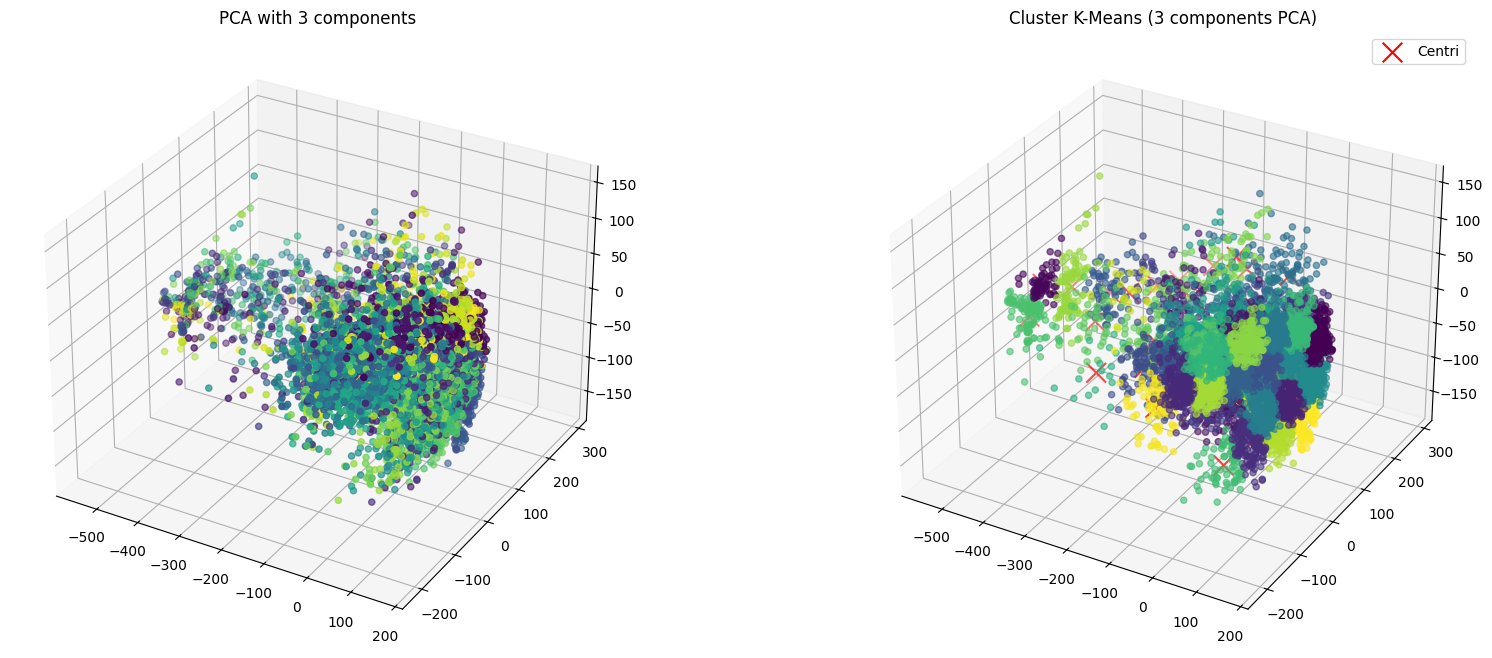

PCA n_components: 3
Adjusted Rand Index: 0.017766176903970025
Homogeneity: 0.5408844616480384, Completeness: 0.5928672292537587, V-Measure: 0.5656841347131615
Silhouette Score: 0.22010362201347058
Davies-Bouldin Index: 0.9306914831450753

PCA n_components: 8
Adjusted Rand Index: 0.0370504903741373
Homogeneity: 0.5552581742670014, Completeness: 0.6102492941638658, V-Measure: 0.581456435249352
Silhouette Score: 0.1541077550307874
Davies-Bouldin Index: 1.0980368904796143

PCA n_components: 100
Adjusted Rand Index: 0.039339634221185714
Homogeneity: 0.5611561873738372, Completeness: 0.6148626454144877, V-Measure: 0.5867830824465872
Silhouette Score: 0.09823392865898473
Davies-Bouldin Index: 1.6175379903026659

PCA n_components: 250
Adjusted Rand Index: 0.025842582908808746
Homogeneity: 0.520823198320062, Completeness: 0.5967150588680307, V-Measure: 0.5561922259867367
Silhouette Score: 0.04805317639526675
Davies-Bouldin Index: 1.916470032326864

LDA n_components: 3
Adjusted Rand Index: 0.005

In [42]:
# carica i file dalla cartella, senza rifare l'analisi
x_train_pca = pickle.load(open(".str/x_train_pca.pkl", "rb"))
x_train_lda = pickle.load(open(".str/x_train_lda.pkl", "rb"))
x_train_tsne = pickle.load(open(".str/x_train_tsne.pkl", "rb"))
x_valid_pca = pickle.load(open(".str/x_valid_pca.pkl", "rb"))
x_valid_lda = pickle.load(open(".str/x_valid_lda.pkl", "rb"))
x_valid_tsne = pickle.load(open(".str/x_valid_tsne.pkl", "rb"))


fig3d, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': '3d'})

# Grafico 3D PCA con 3 components
ax1.set_title("PCA with 3 components")
scatter3d = ax1.scatter(
    x_train_pca[0][:, 0], 
    x_train_pca[0][:, 1], 
    x_train_pca[0][:, 2], 
    c=y_train, 
    cmap='viridis'
)

# K-Means su pca a 3 components
k_means = KMeans(n_clusters=53).fit(x_train_pca[0])

# Get predicted labels and centroids
labels = k_means.labels_
centers = k_means.cluster_centers_
    
# Grafico 3D PCA con 3 components K-means
ax2.set_title("Cluster K-Means (3 components PCA)")
scatter = ax2.scatter(
    x_train_pca[0][:, 0], 
    x_train_pca[0][:, 1], 
    x_train_pca[0][:, 2], 
    c=labels, 
    cmap='viridis', 
    alpha=0.6
)
ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', marker='x', s=200, label='Centri')

plt.legend()
plt.show()


# pca_components = [3, 8, 100, 250]
for i, n in enumerate(x_train_pca):
    k_means = KMeans(n_clusters=53).fit(n)

    preds = k_means.predict(x_valid_pca[i])
    print(f"PCA n_components: {x_train_pca[i].shape[1]}")
    
    # supervised approach
    # # Adjusted Rand Index, from 0 to 1 (best)
    ari_score = adjusted_rand_score(y_valid, preds)
    print(f"Adjusted Rand Index: {ari_score}")

    # supervised approach
    # Homogeneity: each cluster contains only points of the same class
    # Completeness: all points of each class are assigned to the same cluster
    # V-Measure: harmonic mean between homogeneity and completeness
    # homogeneity and completeness goes from 0 (punti all'interno di un cluster 
    # appartengono a più classi diverse) to 1 (tutti i punti all'interno di un 
    # cluster appartengono alla stessa classe)
    homogeneity = homogeneity_score(y_valid, preds)
    completeness = completeness_score(y_valid, preds)
    v_measure = v_measure_score(y_valid, preds)
    print(f"Homogeneity: {homogeneity}, Completeness: {completeness}, V-Measure: {v_measure}")

    # unsupervised approach
    # Silhouette Score
    # 1: Clustering ben definito
    # 0: I cluster si sovrappongono
    # −1: I punti sono nel cluster sbagliato
    silhouette = silhouette_score(x_valid_pca[i], preds)
    print(f"Silhouette Score: {silhouette}")

    # unsupervised approach
    # Davies-Bouldin Index
    # Misura la compattezza e separazione tra i cluster. Valori più bassi indicano cluster migliori.
    db_index = davies_bouldin_score(x_valid_pca[i], preds)
    print(f"Davies-Bouldin Index: {db_index}\n")
    

# lda_components = [3, 10, 25, 50]
for i, n in enumerate(x_train_lda):
    k_means = KMeans(n_clusters=53).fit(n)

    preds = k_means.predict(x_valid_lda[i])
    print(f"LDA n_components: {x_train_lda[i].shape[1]}")
    
    # supervised approach
    ari_score = adjusted_rand_score(y_valid, preds)
    print(f"Adjusted Rand Index: {ari_score}")

    # supervised approach
    homogeneity = homogeneity_score(y_valid, preds)
    completeness = completeness_score(y_valid, preds)
    v_measure = v_measure_score(y_valid, preds)
    print(f"Homogeneity: {homogeneity}, Completeness: {completeness}, V-Measure: {v_measure}")

    # unsupervised approach
    silhouette = silhouette_score(x_valid_lda[i], preds)
    print(f"Silhouette Score: {silhouette}")

    # unsupervised approach
    db_index = davies_bouldin_score(x_valid_lda[i], preds)
    print(f"Davies-Bouldin Index: {db_index}\n")
    


## GMM ##

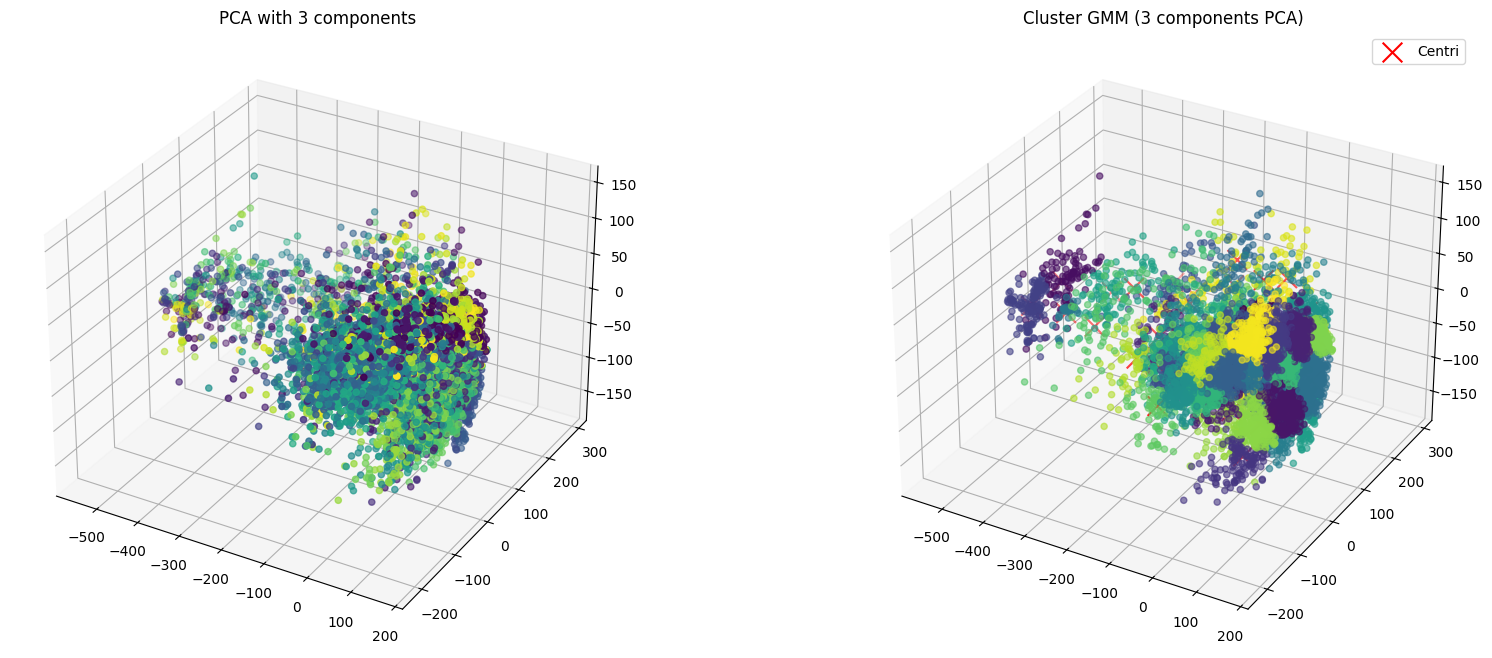

PCA n_components: 3
Adjusted Rand Index: 0.01574735761050965
Homogeneity: 0.5400713171314573, Completeness: 0.590796003196331, V-Measure: 0.564296040511204
Silhouette Score: 0.16188277926616065
Davies-Bouldin Index: 1.1138987565211984

PCA n_components: 8
Adjusted Rand Index: 0.06558275484106686
Homogeneity: 0.5769365244086426, Completeness: 0.6348209632865528, V-Measure: 0.6044962030759358
Silhouette Score: 0.02410780915241319
Davies-Bouldin Index: 1.6941787118066045

PCA n_components: 100
Adjusted Rand Index: 0.03368377842140072
Homogeneity: 0.42473653777304854, Completeness: 0.5719422943532472, V-Measure: 0.4874685446892072
Silhouette Score: -0.036847683672004715
Davies-Bouldin Index: 2.2523830487343504

PCA n_components: 250
Adjusted Rand Index: 0.004032086297460162
Homogeneity: 0.13464900877494518, Completeness: 0.5057089744717378, V-Measure: 0.21267232992387705
Silhouette Score: -0.12941316427644156
Davies-Bouldin Index: 3.2318179738799193

LDA n_components: 3
Adjusted Rand Index

In [43]:

x_train_pca = pickle.load(open(".str/x_train_pca.pkl", "rb"))
x_train_lda = pickle.load(open(".str/x_train_lda.pkl", "rb"))
x_train_tsne = pickle.load(open(".str/x_train_tsne.pkl", "rb"))
x_valid_pca = pickle.load(open(".str/x_valid_pca.pkl", "rb"))
x_valid_lda = pickle.load(open(".str/x_valid_lda.pkl", "rb"))
x_valid_tsne = pickle.load(open(".str/x_valid_tsne.pkl", "rb"))


fig3d, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': '3d'})

# Grafico 3D PCA con 3 components
ax1.set_title("PCA with 3 components")
scatter3d = ax1.scatter(
    x_train_pca[0][:, 0], 
    x_train_pca[0][:, 1], 
    x_train_pca[0][:, 2], 
    c=y_train, 
    cmap='viridis'
)

# GMM su PCA con 3 componenti
gmm = GaussianMixture(n_components=53).fit(x_train_pca[0])

# Predicted labels and centroids for GMM
labels = gmm.predict(x_train_pca[0])
centers = gmm.means_

# Grafico 3D PCA con 3 components e clustering GMM
ax2.set_title("Cluster GMM (3 components PCA)")
scatter = ax2.scatter(
    x_train_pca[0][:, 0], 
    x_train_pca[0][:, 1], 
    x_train_pca[0][:, 2], 
    c=labels, 
    cmap='viridis', 
    alpha=0.6
)
ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', marker='x', s=200, label='Centri')

plt.legend()
plt.show()

# PCA
for i, n in enumerate(x_train_pca):
    gmm = GaussianMixture(n_components=53).fit(n)

    preds = gmm.predict(x_valid_pca[i])
    print(f"PCA n_components: {x_train_pca[i].shape[1]}")

    # supervised approach
    ari_score = adjusted_rand_score(y_valid, preds)
    print(f"Adjusted Rand Index: {ari_score}")

    homogeneity = homogeneity_score(y_valid, preds)
    completeness = completeness_score(y_valid, preds)
    v_measure = v_measure_score(y_valid, preds)
    print(f"Homogeneity: {homogeneity}, Completeness: {completeness}, V-Measure: {v_measure}")

    # unsupervised approach
    silhouette = silhouette_score(x_valid_pca[i], preds)
    print(f"Silhouette Score: {silhouette}")

    db_index = davies_bouldin_score(x_valid_pca[i], preds)
    print(f"Davies-Bouldin Index: {db_index}\n")

# LDA
for i, n in enumerate(x_train_lda):
    gmm = GaussianMixture(n_components=53).fit(n)

    preds = gmm.predict(x_valid_lda[i])
    print(f"LDA n_components: {x_train_lda[i].shape[1]}")

    # supervised approach
    ari_score = adjusted_rand_score(y_valid, preds)
    print(f"Adjusted Rand Index: {ari_score}")

    if (ari_score == 0):
        continue

    homogeneity = homogeneity_score(y_valid, preds)
    completeness = completeness_score(y_valid, preds)
    v_measure = v_measure_score(y_valid, preds)
    print(f"Homogeneity: {homogeneity}, Completeness: {completeness}, V-Measure: {v_measure}")

    # unsupervised approach
    silhouette = silhouette_score(x_valid_lda[i], preds)
    print(f"Silhouette Score: {silhouette}")

    db_index = davies_bouldin_score(x_valid_lda[i], preds)
    print(f"Davies-Bouldin Index: {db_index}\n")



## Mean-Shift ##

In [45]:
x_train_pca = pickle.load(open(".str/x_train_pca.pkl", "rb"))
x_train_lda = pickle.load(open(".str/x_train_lda.pkl", "rb"))
x_train_tsne = pickle.load(open(".str/x_train_tsne.pkl", "rb"))
x_valid_pca = pickle.load(open(".str/x_valid_pca.pkl", "rb"))
x_valid_lda = pickle.load(open(".str/x_valid_lda.pkl", "rb"))
x_valid_tsne = pickle.load(open(".str/x_valid_tsne.pkl", "rb"))


# Mean-Shift su PCA con n_componets
# calcola in maniera automatica il numero di cluster
for i, n in enumerate(x_train_pca):
    mean_shift = MeanShift()
    mean_shift.fit(n)
    
    preds = mean_shift.predict(x_valid_pca[i])
    print(f"PCA n_components: {x_train_pca[i].shape[1]}")
    
    # supervised approach
    ari_score = adjusted_rand_score(y_valid, preds)
    print(f"Adjusted Rand Index: {ari_score}")

    homogeneity = homogeneity_score(y_valid, preds)
    completeness = completeness_score(y_valid, preds)
    v_measure = v_measure_score(y_valid, preds)
    print(f"Homogeneity: {homogeneity}, Completeness: {completeness}, V-Measure: {v_measure}")

    # unsupervised approach
    silhouette = silhouette_score(x_valid_pca[i], preds)
    print(f"Silhouette Score: {silhouette}")

    db_index = davies_bouldin_score(x_valid_pca[i], preds)
    print(f"Davies-Bouldin Index: {db_index}\n")

# Mean-Shift su LDA con n_componets
for i, n in enumerate(x_train_lda):
    mean_shift = MeanShift()
    mean_shift.fit(n)

    preds = mean_shift.predict(x_valid_lda[i])
    print(f"LDA n_components: {x_train_lda[i].shape[1]}")
    
    # supervised approach
    ari_score = adjusted_rand_score(y_valid, preds)
    print(f"Adjusted Rand Index: {ari_score}")

    homogeneity = homogeneity_score(y_valid, preds)
    completeness = completeness_score(y_valid, preds)
    v_measure = v_measure_score(y_valid, preds)
    print(f"Homogeneity: {homogeneity}, Completeness: {completeness}, V-Measure: {v_measure}")

    # unsupervised approach
    silhouette = silhouette_score(x_valid_lda[i], preds)
    print(f"Silhouette Score: {silhouette}")

    db_index = davies_bouldin_score(x_valid_lda[i], preds)
    print(f"Davies-Bouldin Index: {db_index}\n")

PCA n_components: 3
Adjusted Rand Index: -0.00010699828208313766
Homogeneity: 0.020936614735481075, Completeness: 0.36457369844074267, V-Measure: 0.03959914329687015
Silhouette Score: 0.6903664504378789
Davies-Bouldin Index: 0.44321562613764043

PCA n_components: 8
Adjusted Rand Index: -2.466897321566233e-05
Homogeneity: 0.0244828050316318, Completeness: 0.35101511988502226, V-Measure: 0.04577300790787251
Silhouette Score: 0.5853229828177758
Davies-Bouldin Index: 0.6955643868743379

PCA n_components: 100
Adjusted Rand Index: 1.440824316174488e-05
Homogeneity: 0.030759931258220782, Completeness: 0.4045991033516488, V-Measure: 0.05717322768958724
Silhouette Score: 0.37760425759191374
Davies-Bouldin Index: 0.7479111209269119

PCA n_components: 250
Adjusted Rand Index: -6.439386970360422e-05
Homogeneity: 0.03279727526053949, Completeness: 0.4245999909394777, V-Measure: 0.06089115002438595
Silhouette Score: 0.2991689330271945
Davies-Bouldin Index: 0.7049489096797543

LDA n_components: 3
Adj

## KNN ##

In [5]:
x_train_pca = pickle.load(open(".str/x_train_pca.pkl", "rb"))
x_train_lda = pickle.load(open(".str/x_train_lda.pkl", "rb"))
x_train_tsne = pickle.load(open(".str/x_train_tsne.pkl", "rb"))
x_valid_pca = pickle.load(open(".str/x_valid_pca.pkl", "rb"))
x_valid_lda = pickle.load(open(".str/x_valid_lda.pkl", "rb"))
x_valid_tsne = pickle.load(open(".str/x_valid_tsne.pkl", "rb"))

knn_values = [3, 5, 10, 50, 100]

# k-NN su PCA con diverse componenti
for value in knn_values:
    for i, n in enumerate(x_train_pca):
        #break
        knn = KNeighborsClassifier(n_neighbors=value)  # Usa k=5 come valore iniziale
        knn.fit(n, y_train)  # Addestramento su x_train_pca e y_train
        
        preds = knn.predict(x_valid_pca[i])  # Predizioni su x_valid_pca
        print(f"k: {value} - PCA n_components: {x_train_pca[i].shape[1]}")
        
        # Accuracy
        acc = accuracy_score(y_valid, preds)
        print(f"Accuracy: {acc}")
        
        # Classification report (Precision, Recall, F1-score per classe)
        #print("Classification Report:")
        #print(classification_report(y_valid, preds))
        
        # Confusion Matrix
        '''
        cm = confusion_matrix(y_valid, preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
        plt.title(f"Confusion Matrix (PCA n_components={x_train_pca[i].shape[1]})")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()
        '''
    print("\n")

# k-NN su LDA con diverse componenti
for value in knn_values:
    for i, n in enumerate(x_train_lda):
        #break
        knn = KNeighborsClassifier(n_neighbors=value)  # Usa k=5 come valore iniziale
        knn.fit(n, y_train)  # Addestramento su x_train_lda e y_train

        preds = knn.predict(x_valid_lda[i])  # Predizioni su x_valid_lda
        print(f"k: {value} - LDA n_components: {x_train_lda[i].shape[1]}")
        
        # Accuracy
        acc = accuracy_score(y_valid, preds)
        print(f"Accuracy: {acc}")
        
        # Classification report (Precision, Recall, F1-score per classe)
        #print("Classification Report:")
        #print(classification_report(y_valid, preds))
        
        # Confusion Matrix
        '''
        cm = confusion_matrix(y_valid, preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
        plt.title(f"Confusion Matrix (LDA n_components={x_train_lda[i].shape[1]})")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()
        '''
    print("\n")


k: 3 - PCA n_components: 3
Accuracy: 0.08679245283018867
k: 3 - PCA n_components: 8
Accuracy: 0.2641509433962264
k: 3 - PCA n_components: 100
Accuracy: 0.3622641509433962
k: 3 - PCA n_components: 250
Accuracy: 0.35094339622641507


k: 5 - PCA n_components: 3
Accuracy: 0.0830188679245283
k: 5 - PCA n_components: 8
Accuracy: 0.24528301886792453
k: 5 - PCA n_components: 100
Accuracy: 0.3132075471698113
k: 5 - PCA n_components: 250
Accuracy: 0.33962264150943394


k: 10 - PCA n_components: 3
Accuracy: 0.10943396226415095
k: 10 - PCA n_components: 8
Accuracy: 0.26037735849056604
k: 10 - PCA n_components: 100
Accuracy: 0.3320754716981132
k: 10 - PCA n_components: 250
Accuracy: 0.32075471698113206


k: 50 - PCA n_components: 3
Accuracy: 0.09433962264150944
k: 50 - PCA n_components: 8
Accuracy: 0.23018867924528302
k: 50 - PCA n_components: 100
Accuracy: 0.3169811320754717
k: 50 - PCA n_components: 250
Accuracy: 0.29056603773584905


k: 100 - PCA n_components: 3
Accuracy: 0.09433962264150944
k: 

## SVM ##

In [4]:
x_train_pca = pickle.load(open(".str/x_train_pca.pkl", "rb"))
x_train_lda = pickle.load(open(".str/x_train_lda.pkl", "rb"))
x_train_tsne = pickle.load(open(".str/x_train_tsne.pkl", "rb"))
x_valid_pca = pickle.load(open(".str/x_valid_pca.pkl", "rb"))
x_valid_lda = pickle.load(open(".str/x_valid_lda.pkl", "rb"))
x_valid_tsne = pickle.load(open(".str/x_valid_tsne.pkl", "rb"))

# SVM PCA
for i, n in enumerate(x_train_pca):
    svm = SVC(kernel='linear')  # kernel lineare
    svm.fit(n, y_train) 

    preds = svm.predict(x_valid_pca[i])
    print(f"PCA n_components: {x_train_pca[i].shape[1]}")

    # Accuracy
    acc = accuracy_score(y_valid, preds)
    print(f"Accuracy: {acc}")

    # Classification report (Precision, Recall, F1-score per classe)
    #print("Classification Report:")
    #print(classification_report(y_valid, preds))


# SVM LDA
for i, n in enumerate(x_train_lda):
    svm = SVC(kernel='linear')
    svm.fit(n, y_train)

    preds = svm.predict(x_valid_lda[i])
    print(f"LDA n_components: {x_train_lda[i].shape[1]}")

    # Accuracy
    acc = accuracy_score(y_valid, preds)
    print(f"Accuracy: {acc}")

    # Classification report (Precision, Recall, F1-score per classe)
    #print("Classification Report:")
    #print(classification_report(y_valid, preds))



PCA n_components: 3
Accuracy: 0.08679245283018867
PCA n_components: 8
Accuracy: 0.2679245283018868
PCA n_components: 100
Accuracy: 0.3886792452830189
PCA n_components: 250
Accuracy: 0.47547169811320755
LDA n_components: 3
Accuracy: 0.022641509433962263
LDA n_components: 10
Accuracy: 0.03773584905660377
LDA n_components: 25
Accuracy: 0.04905660377358491
LDA n_components: 50
Accuracy: 0.06415094339622641


## SGD ##

In [4]:
x_train_pca = pickle.load(open(".str/x_train_pca.pkl", "rb"))
x_train_lda = pickle.load(open(".str/x_train_lda.pkl", "rb"))
x_train_tsne = pickle.load(open(".str/x_train_tsne.pkl", "rb"))
x_valid_pca = pickle.load(open(".str/x_valid_pca.pkl", "rb"))
x_valid_lda = pickle.load(open(".str/x_valid_lda.pkl", "rb"))
x_valid_tsne = pickle.load(open(".str/x_valid_tsne.pkl", "rb"))

# SGD su PCA
for i, n in enumerate(x_train_pca):
    sgd = SGDClassifier(loss='hinge')  # Modello SGD con hinge loss
    sgd.fit(n, y_train) 

    preds = sgd.predict(x_valid_pca[i])
    print(f"PCA n_components: {x_train_pca[i].shape[1]}")

    # Accuracy
    acc = accuracy_score(y_valid, preds)
    print(f"Accuracy: {acc}")

    # Classification report (Precision, Recall, F1-score per classe)
    #print("Classification Report:")
    #print(classification_report(y_valid, preds))

# SGD su LDA
for i, n in enumerate(x_train_lda):
    sgd = SGDClassifier(loss='hinge')
    sgd.fit(n, y_train)

    preds = sgd.predict(x_valid_lda[i])
    print(f"LDA n_components: {x_train_lda[i].shape[1]}")

    # Accuracy
    acc = accuracy_score(y_valid, preds)
    print(f"Accuracy: {acc}")

    # Classification report (Precision, Recall, F1-score per classe)
    #print("Classification Report:")
    #print(classification_report(y_valid, preds))

    


PCA n_components: 3
Accuracy: 0.07924528301886792
PCA n_components: 8
Accuracy: 0.18490566037735848
PCA n_components: 100
Accuracy: 0.37735849056603776
PCA n_components: 250
Accuracy: 0.4339622641509434


C:\Users\fabio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


LDA n_components: 3
Accuracy: 0.022641509433962263


C:\Users\fabio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


LDA n_components: 10
Accuracy: 0.04150943396226415
LDA n_components: 25
Accuracy: 0.10943396226415095
LDA n_components: 50
Accuracy: 0.15471698113207547


## Dataset Loading, feature extraction with ResNet50 and reduction with PCA ##

In [32]:
def load_images_from_directory_and_extract_with_resnet(base_dir, model):
    x = []  # Dati delle immagini
    y = []  # Etichette
    labels = []  # Mappa delle etichette

    # id - valore di ogni dir ordinata dentro a base_dir (id per la classe di appartenenza)
    for label_idx, label_name in enumerate(sorted(os.listdir(base_dir))):
        label_path = os.path.join(base_dir, label_name)
        if os.path.isdir(label_path):
            labels.append(label_name)  # per mappare la classe di appartenenza con i nomi
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)
                if file_path.endswith(('.jpg', '.jpeg', '.png')):
                    image = cv2.imread(file_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # da BGR (default OpenCV) ad RGB
                    image = cv2.resize(image, (224, 224)) # non serve, ma per sicurezza
                    # normalizzazione per ResNet50
                    image = preprocess_input(image)
                    x.append(image) 
                    y.append(label_idx)

    x = np.array(x)
    y = np.array(y)

    # Estrai le feature utilizzando il modello pre-addestrato
    features = model.predict(x, batch_size=32, verbose=1)

    return features, y, labels


# modello ResNet50 senza il top classifier (solo feature extractor)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# dir del dataset
base_dir = "dataset"

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

x_train, y_train, labels_train = load_images_from_directory_and_extract_with_resnet(train_dir, resnet_model)
x_valid, y_valid, labels_valid = load_images_from_directory_and_extract_with_resnet(valid_dir, resnet_model)
x_test, y_test, labels_test = load_images_from_directory_and_extract_with_resnet(test_dir, resnet_model) 

# assert di controllo, tutti i nomi uguali
assert labels_train == labels_valid == labels_test, "Le etichette non corrispondono tra train, valid e test"

print(f"Train set before: {x_train.shape}, Labels: {len(np.unique(y_train))}")
print(f"Validation set before: {x_valid.shape}, Labels: {len(np.unique(y_valid))}")
print(f"Test set before: {x_test.shape}, Labels: {len(np.unique(y_test))}")

# appiattisce i dati in (n_samples, n_features) per PCA (vuole <= 2 dimensioni, non 4)
x_train = x_train.reshape(x_train.shape[0], -1)  # Appiattisce in (n_samples, n_features)
x_valid = x_valid.reshape(x_valid.shape[0], -1)  # Appiattisce in (n_samples, n_features)
x_test = x_test.reshape(x_test.shape[0], -1)  # Appiattisce in (n_samples, n_features)

print(f"Train set after: {x_train.shape}, Labels: {len(np.unique(y_train))}")
print(f"Validation set after: {x_valid.shape}, Labels: {len(np.unique(y_valid))}")
print(f"Test set after: {x_test.shape}, Labels: {len(np.unique(y_test))}")

# PCA part
pca_components= [3, 8, 100, 500, 1000, 2000]
x_train_pca = []
x_valid_pca = []

print("PCA Explained Variance Ratio (EVR)")
for n in pca_components:
    #break
    pca = PCA(n_components=n)
    x_train_pca.append(pca.fit_transform(x_train))  # dati
    # solo transform su dati di validazione
    x_valid_pca.append(pca.transform(x_valid))  # dati
    print("n_components: ", n, "- EVR: ", np.sum(pca.explained_variance_ratio_, axis=0))


# LDA part #
lda_components = [3, 10, 25, 50]
x_train_lda = []
x_valid_lda = []

print("LDA Explained Variance Ratio (EVR)")
for n in lda_components:
    #break
    lda = LinearDiscriminantAnalysis(n_components=n)
    x_train_lda.append(lda.fit_transform(x_train, y_train))  # dati e label
    x_valid_lda.append(lda.transform(x_valid))  # dati e label
    print("n_components: ", n, "- EVR: ", np.sum(lda.explained_variance_ratio_, axis=0))


pickle.dump(x_train_pca, open(".rsn/x_train_pca.pkl", "wb"))
pickle.dump(x_valid_pca, open(".rsn/x_valid_pca.pkl", "wb"))
pickle.dump(x_train_lda, open(".rsn/x_train_lda.pkl", "wb"))
pickle.dump(x_valid_lda, open(".rsn/x_valid_lda.pkl", "wb"))



239/239 ━━━━━━━━━━━━━━━━━━━━ 199s 826ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 793ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 753ms/step
Train set before: (7624, 7, 7, 2048), Labels: 53
Validation set before: (265, 7, 7, 2048), Labels: 53
Test set before: (265, 7, 7, 2048), Labels: 53
Train set after: (7624, 100352), Labels: 53
Validation set after: (265, 100352), Labels: 53
Test set after: (265, 100352), Labels: 53
PCA Explained Variance Ratio (EVR)
n_components:  3 - EVR:  0.13458855
n_components:  8 - EVR:  0.21959572
n_components:  100 - EVR:  0.48133352
n_components:  500 - EVR:  0.6685709
n_components:  1000 - EVR:  0.75657916
n_components:  2000 - EVR:  0.85262716
LDA Explained Variance Ratio (EVR)
n_components:  3 - EVR:  0.6807023281640994
n_components:  10 - EVR:  0.7999018740742816
n_components:  25 - EVR:  0.9081669060252925
n_components:  50 - EVR:  0.9955062267040001


## KNN with ResNet ##

k: 3 - PCA n_components: 3
Accuracy: 0.13584905660377358
k: 3 - PCA n_components: 8
Accuracy: 0.3132075471698113
k: 3 - PCA n_components: 100
Accuracy: 0.46037735849056605
k: 3 - PCA n_components: 500
Accuracy: 0.46037735849056605
k: 3 - PCA n_components: 1000
Accuracy: 0.4641509433962264
k: 3 - PCA n_components: 2000
Accuracy: 0.4641509433962264


k: 5 - PCA n_components: 3
Accuracy: 0.16981132075471697
k: 5 - PCA n_components: 8
Accuracy: 0.3283018867924528
k: 5 - PCA n_components: 100
Accuracy: 0.4339622641509434
k: 5 - PCA n_components: 500
Accuracy: 0.47924528301886793
k: 5 - PCA n_components: 1000
Accuracy: 0.5018867924528302
k: 5 - PCA n_components: 2000
Accuracy: 0.49433962264150944


k: 10 - PCA n_components: 3
Accuracy: 0.1509433962264151
k: 10 - PCA n_components: 8
Accuracy: 0.3283018867924528
k: 10 - PCA n_components: 100
Accuracy: 0.4679245283018868
k: 10 - PCA n_components: 500
Accuracy: 0.5207547169811321
k: 10 - PCA n_components: 1000
Accuracy: 0.5320754716981132
k: 10 

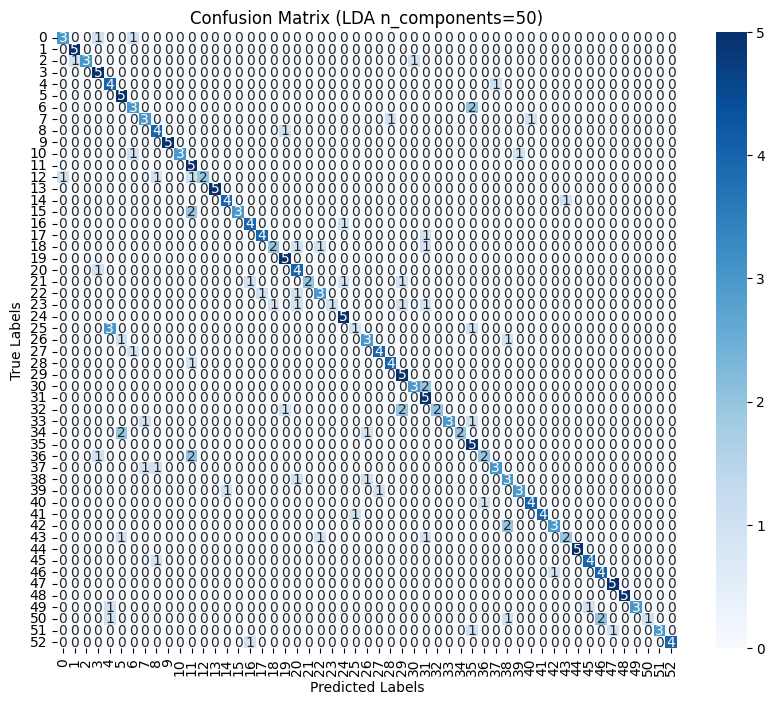



k: 5 - LDA n_components: 3
Accuracy: 0.2
k: 5 - LDA n_components: 10
Accuracy: 0.44150943396226416
k: 5 - LDA n_components: 25
Accuracy: 0.7018867924528301


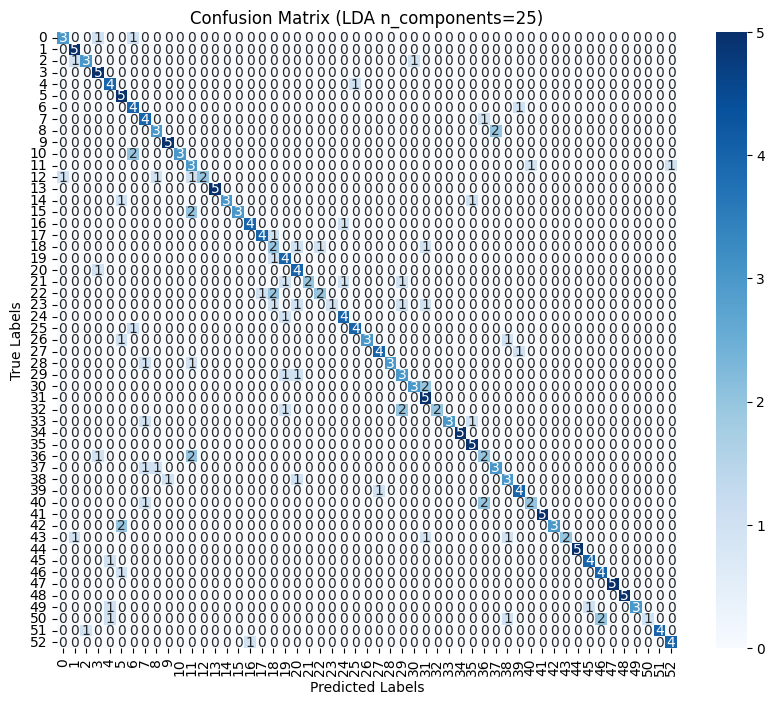

k: 5 - LDA n_components: 50
Accuracy: 0.7169811320754716


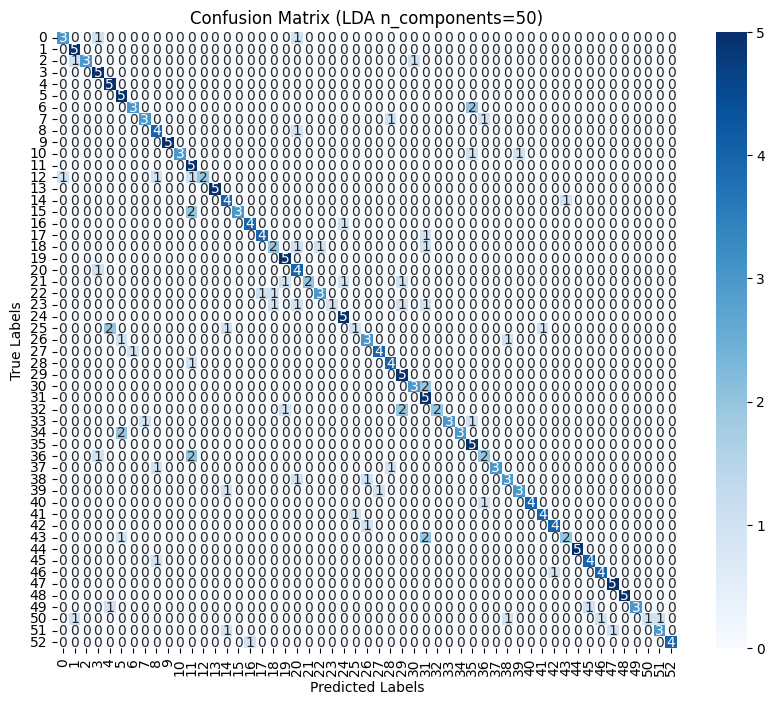



k: 10 - LDA n_components: 3
Accuracy: 0.21132075471698114
k: 10 - LDA n_components: 10
Accuracy: 0.45660377358490567
k: 10 - LDA n_components: 25
Accuracy: 0.7094339622641509


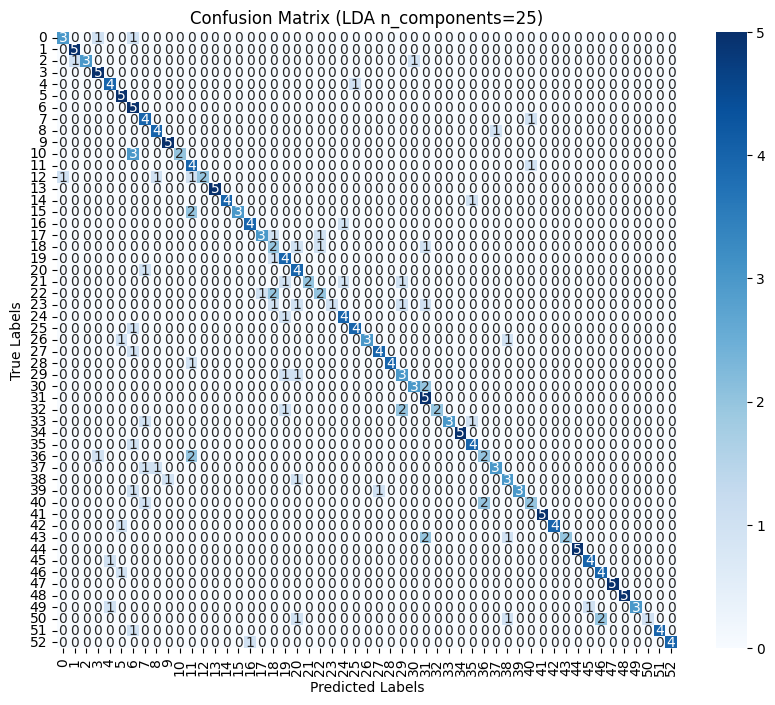

k: 10 - LDA n_components: 50
Accuracy: 0.7283018867924528


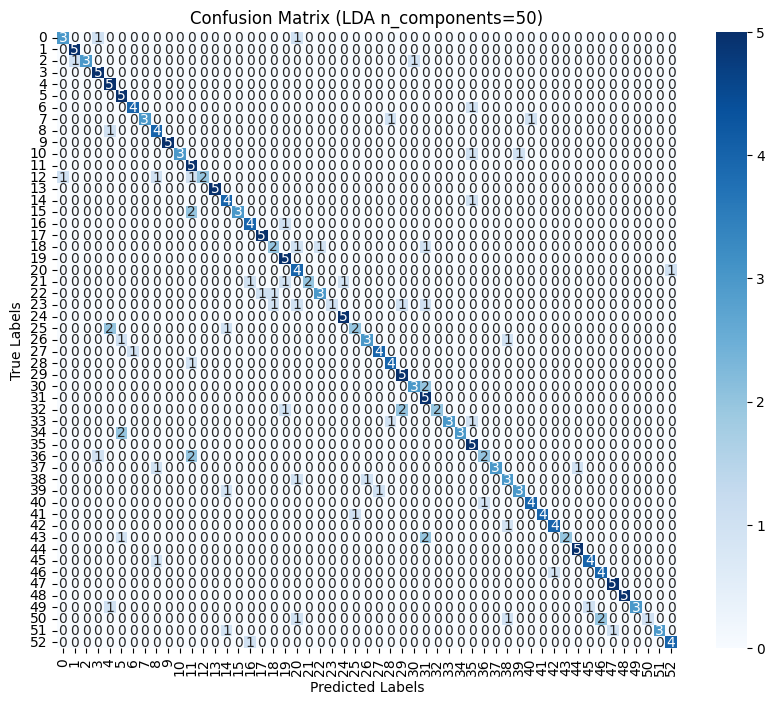



k: 50 - LDA n_components: 3
Accuracy: 0.2037735849056604
k: 50 - LDA n_components: 10
Accuracy: 0.47924528301886793
k: 50 - LDA n_components: 25
Accuracy: 0.720754716981132


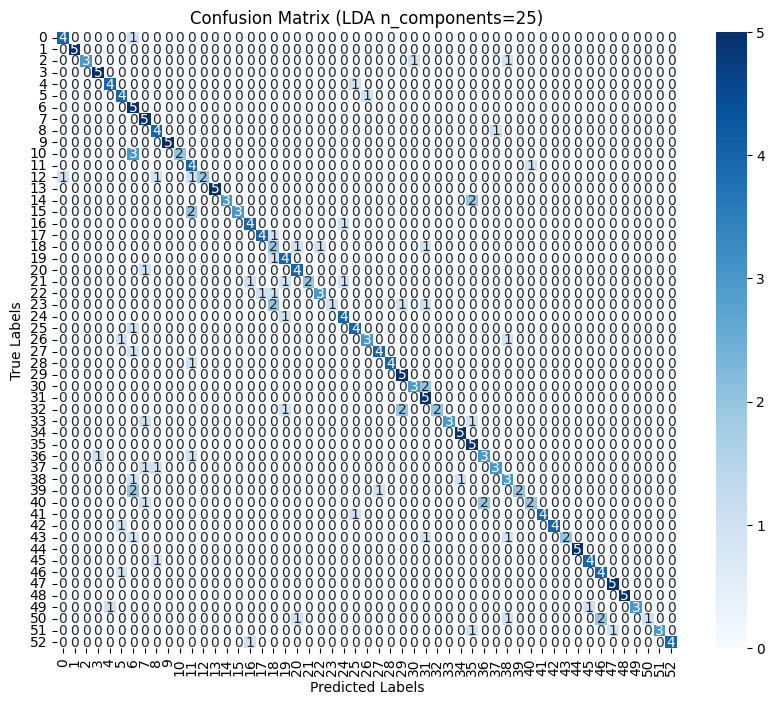

k: 50 - LDA n_components: 50
Accuracy: 0.7283018867924528


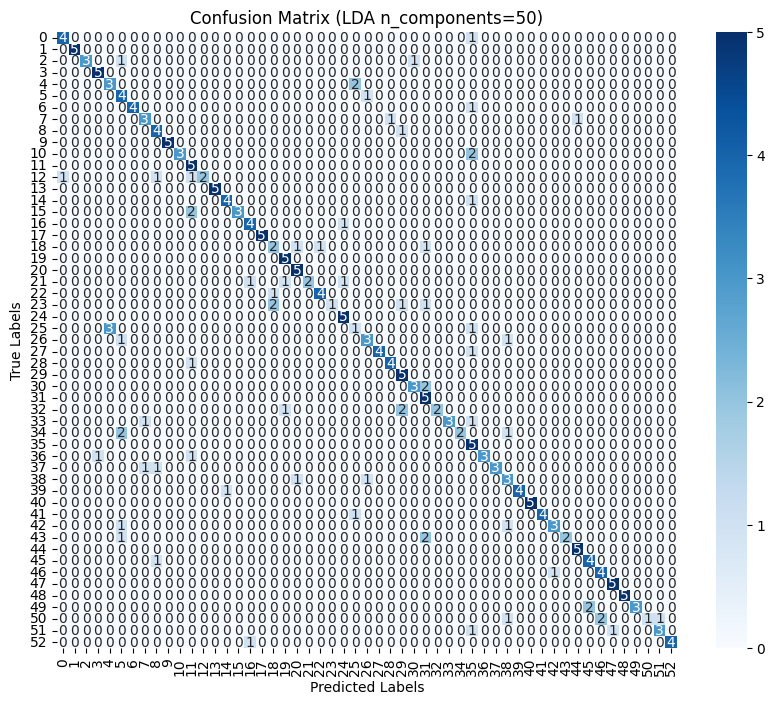



k: 100 - LDA n_components: 3
Accuracy: 0.20754716981132076
k: 100 - LDA n_components: 10
Accuracy: 0.47924528301886793
k: 100 - LDA n_components: 25
Accuracy: 0.7320754716981132


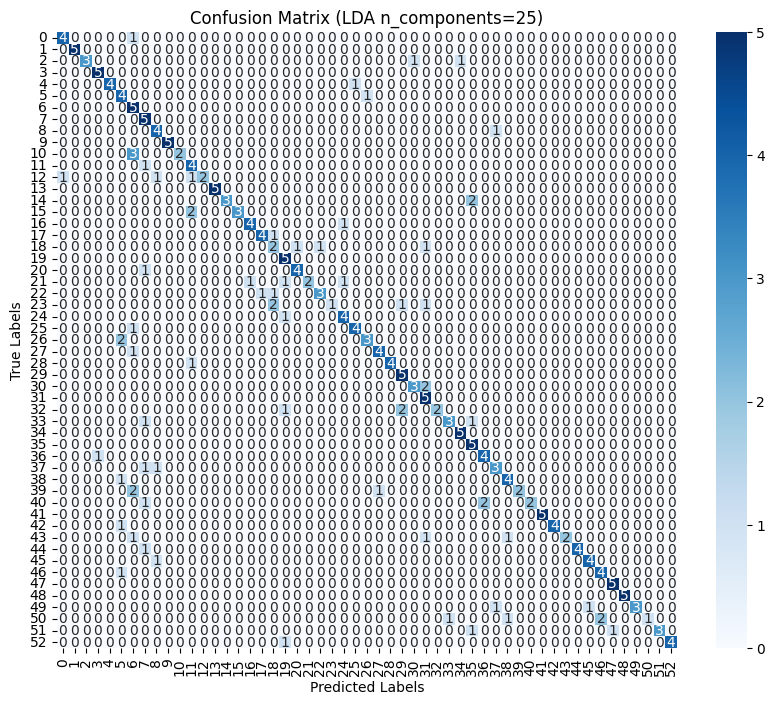

k: 100 - LDA n_components: 50
Accuracy: 0.7283018867924528


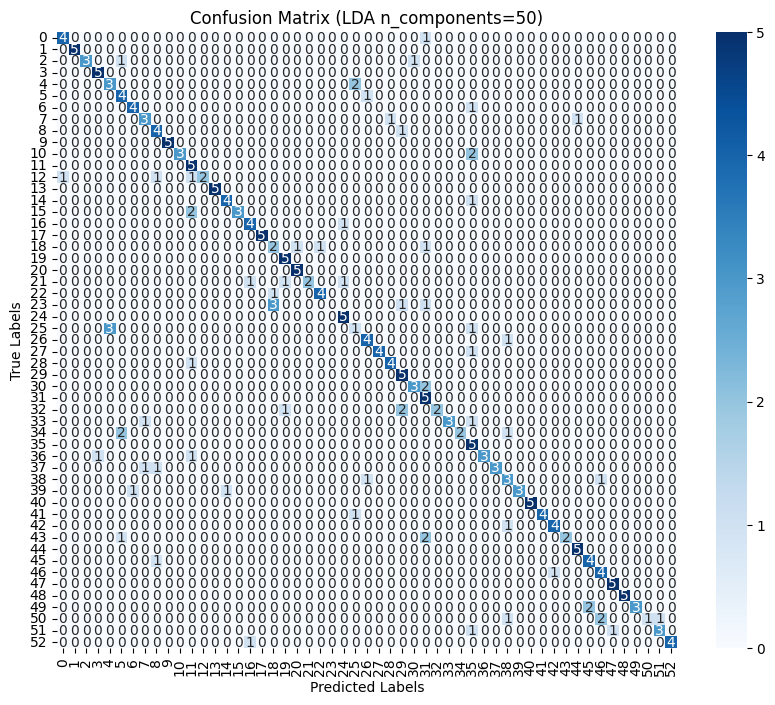



k: 500 - LDA n_components: 3
Accuracy: 0.14339622641509434
k: 500 - LDA n_components: 10
Accuracy: 0.35094339622641507
k: 500 - LDA n_components: 25
Accuracy: 0.41509433962264153
k: 500 - LDA n_components: 50
Accuracy: 0.5547169811320755




In [6]:
x_train_pca = pickle.load(open(".rsn/x_train_pca.pkl", "rb"))
x_valid_pca = pickle.load(open(".rsn/x_valid_pca.pkl", "rb"))
x_train_lda = pickle.load(open(".rsn/x_train_lda.pkl", "rb"))
x_valid_lda = pickle.load(open(".rsn/x_valid_lda.pkl", "rb"))


knn_values = [3, 5, 10, 50, 100, 500]

# k-NN su PCA con diverse componenti
for value in knn_values:
    for i, n in enumerate(x_train_pca):
        
        knn = KNeighborsClassifier(n_neighbors=value)  # Usa k=5 come valore iniziale
        knn.fit(n, y_train)  # Addestramento su x_train_pca e y_train
        
        preds = knn.predict(x_valid_pca[i])  # Predizioni su x_valid_pca
        print(f"k: {value} - PCA n_components: {x_train_pca[i].shape[1]}")
        
        # Accuracy
        acc = accuracy_score(y_valid, preds)
        print(f"Accuracy: {acc}")
        
        # Classification report (Precision, Recall, F1-score per classe)
        #print("Classification Report:")
        #print(classification_report(y_valid, preds))
        
    print("\n")

# k-NN su LDA con diverse componenti
for value in knn_values:
    for i, n in enumerate(x_train_lda):
        #break
        knn = KNeighborsClassifier(n_neighbors=value)  # Usa k=5 come valore iniziale
        knn.fit(n, y_train)  # Addestramento su x_train_lda e y_train

        preds = knn.predict(x_valid_lda[i])  # Predizioni su x_valid_lda
        print(f"k: {value} - LDA n_components: {x_train_lda[i].shape[1]}")
        
        # Accuracy of confusion matrix
        acc = accuracy_score(y_valid, preds)
        print(f"Accuracy: {acc}")
        
        # Classification report (Precision, Recall, F1-score per classe)
        #print("Classification Report:")
        #print(classification_report(y_valid, preds))

        # Confusion Matrix
        if (acc > 0.7):
            cm = confusion_matrix(y_valid, preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
            plt.title(f"Confusion Matrix (LDA n_components={x_train_lda[i].shape[1]})")
            plt.xlabel("Predicted Labels")
            plt.ylabel("True Labels")
            plt.show()
        
        
    print("\n")